In [1]:
import numpy as np
import pandas as pd

import confusion_plot

import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
titanic = pd.read_csv('../../data/titanic/clean.csv')

In [3]:
titanic.head()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Family Members,Cabin_A10,Cabin_A11,Cabin_A14,...,Embarked_C,Embarked_NaN,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass category_1,Pclass category_2,Pclass category_3,Survived
0,29.881138,69.5500,2.0,793.0,3.0,8.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,24.000000,69.3000,0.0,370.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,24.000000,82.2667,0.0,1179.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,18.000000,7.7500,0.0,954.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,9.000000,15.2458,1.0,853.0,3.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
titanic.shape

(1309, 204)

In [5]:
y = titanic['Survived']
X = titanic.drop(['PassengerId','Survived'], axis=1)
X = X.values
y = y.values
X, y = shuffle(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# The Simplest Decision Tree

### Deterministic:

Let's suppose people in the age bracket 22 - 25 are the [strongest](https://www.swimmingworldmagazine.com/news/age-analysis-of-rio-swimming-finalists-the-older-the-better/) swimmers, so let's take the mean and build a model which predicts everyone over 23.5 will die, and everyone under 23.5 will survive:

In [7]:
preds = np.zeros(X_test.shape[0])

for i in range(X_test.shape[0]):
    if X_test[i,0] > 23.5:
        preds[i] = 1

In [8]:
accuracy_score(preds, y_test)

0.48854961832061067

Normalized confusion matrix
[[0.2987013  0.7012987 ]
 [0.24074074 0.75925926]]


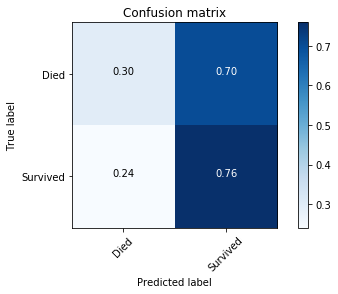

In [9]:
conf = confusion_matrix(y_test, preds)
confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)

### Learning

In machine learning, our algos deterimine the decision boundaries, so let's train one up!

In [11]:
boundary = 0
print('initial decision boundry:', boundary)

learning_rate = 1

for i in range(X_train.shape[0]):
    # survival, but age is less than boundary
    if (y_train[i] == 1) & (X_train[i,0] < boundary):
        boundary -= learning_rate
        
    # death, but age is greater than boundary
    if (y_train[i] == 0) & (X_train[i,0] > boundary):
        boundary += learning_rate

print('final decision boundry:', boundary)

initial decision boundry: 0
final decision boundry: 33


In [12]:
preds = np.zeros(X_test.shape[0])

for i in range(X_test.shape[0]):
    if (X_test[i,0] < boundary) & (X_test[i,0] > boundary-4):
        preds[i] = 1

In [13]:
accuracy_score(preds, y_test)

0.5190839694656488

Normalized confusion matrix
[[0.68831169 0.31168831]
 [0.72222222 0.27777778]]


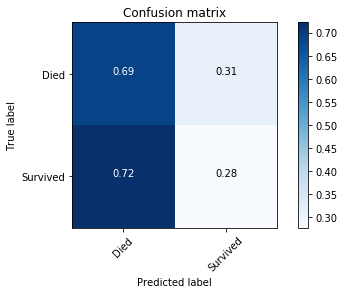

In [14]:
conf = confusion_matrix(y_test, preds)
confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)

# Multifactor Decision Tree

In reality, we want to use all the available features to make a decision.

In [15]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [16]:
accuracy_score(preds, y_test)

0.816793893129771

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.24074074 0.75925926]]


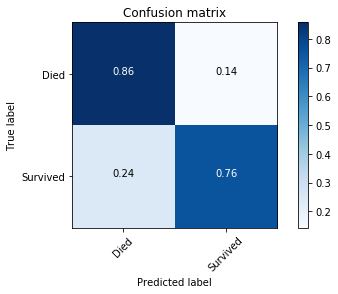

In [17]:
conf = confusion_matrix(y_test, preds)

confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)

In [18]:
import graphviz
cols = list(titanic.columns[:-1])
del cols[3]
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=cols,  
                         class_names=['Died', 'Survived'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("../../data/titanic/titanic")

'../../data/titanic/titanic.pdf'

# Random Forest

Bootstrap Aggregating (Bagging) - training many models in parallel over subsets of resampled data (with replacement). It's like training on bunches of subsets of data and averaging over the resultant decision boundaries.

Boosting - training many models in serial and adding them (with weighting) to a final model. It's like training many times and each time adding a decision boundary.

Random forests - Bagging on samples and features.

In [23]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [24]:
accuracy_score(preds, y_test)

0.8244274809160306

Normalized confusion matrix
[[0.8961039  0.1038961 ]
 [0.27777778 0.72222222]]


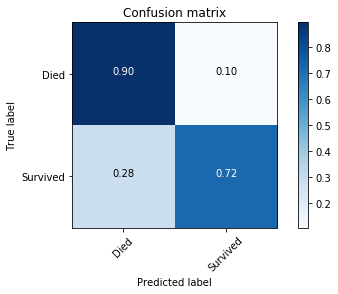

In [25]:
conf = confusion_matrix(y_test, preds)

confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)

# Receiver Operating Characteristic

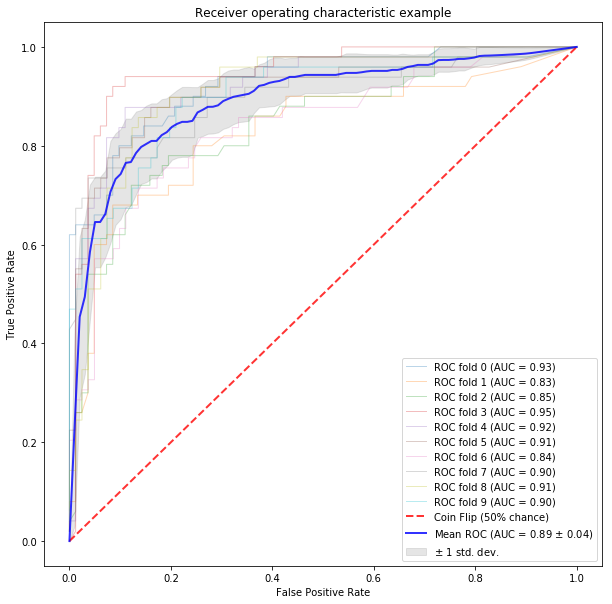

CPU times: user 25.4 s, sys: 2.8 s, total: 28.2 s
Wall time: 15.9 s


In [26]:
%%time

plt.figure(figsize=(10,10))


cv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])

    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Coin Flip (50% chance)', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()